IMPORTS & SETUP

In [49]:
#############
## IMPORTS ##
#############

# Core packages
import os
import glob
from pathlib import Path
import configparser
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Computing
from scipy import stats, signal
from scipy.spatial.distance import euclidean
from scipy.interpolate import splprep, splev
from numpy import linalg as LA

# Graph analysis
import networkx as nx
import phate
import tphate
import scprep
from mpl_toolkits.mplot3d import Axes3D

# Machine learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


In [50]:
######################
## GSTH DEFINTIONS ##
######################

#TRANSITION MATRIX FOR LAZY RANDOM WALKS
def lazy_random_walk(adj):
    d = adj.sum(0)
    P_t = adj/d
    P_t[np.isnan(P_t)] = 0
    P = 0.5 * (np.identity(P_t.shape[0]) + P_t)
    return P

#CALCULATES WAVELET (Manual scattering. Not learnable. Talk to Dhanajay about NeuroGSTH.)
def graph_wavelet(P):
    psi = []
    scales = [1, 2, 4, 8, 16]
    for d1 in scales:
        W_d1 = LA.matrix_power(P, d1) - LA.matrix_power(P, 2 * d1)
        psi.append(W_d1)
    return psi

#0th ORDER FEATURE
def zero_order_feature(A, ro):
    return np.matmul(LA.matrix_power(A, 16), ro)

#1st ORDER FEATURE
def first_order_feature(A, u, wavelet_outputs):
    power_A = LA.matrix_power(A, 16)
    F1_list = []
    
    for wavelet_out in wavelet_outputs:
        F1_list.append(np.matmul(power_A, wavelet_out))
    
    F1 = np.concatenate(F1_list, axis=0)
    return F1

#2nd ORDER FEATURE
def second_order_feature(A, W, u, wavelet_outputs):
    power_A = LA.matrix_power(A, 16)
    F2_list = []
    
    for i in range(1, len(W)):
        for j in range(i):
            u1 = np.matmul(W[i], wavelet_outputs[j])
            u1 = np.abs(u1)
            F2_list.append(np.matmul(power_A, u1))
    
    F2 = np.concatenate(F2_list, axis=0)
    return F2

#MULTI-SCALE FEATURE FUNCTION
def generate_timepoint_feature(adj, ro):
    P = lazy_random_walk(adj)
    W = graph_wavelet(P)
    
    wavelet_outputs = []
    for w in W:
        wavelet_out = np.matmul(w, ro)
        wavelet_outputs.append(np.abs(wavelet_out))
        
    F0 = zero_order_feature(P, ro) #(48 x 7850)
    F1 = first_order_feature(P, ro, wavelet_outputs) #(240 x 7850)
    F2 = second_order_feature(P, W, ro, wavelet_outputs) #(480 x 7850)
    
    F = np.concatenate([F0, F1, F2], axis=0) # (768 x 7850)
    return F

In [51]:
#######################################################
## CREATING XYZ CHANNEL COORDINATES MATRICES (48X3) ##
######################################################

pos_files_path = "/Users/judesack/THESIS_CODE/GSTH/notebooks/POS_files/*subject*.pos"
subject_probe_coords = []
subject_channel_coords = []

# Channel pairs
holder1_pairs = [
    (1, 2), (2, 3), (3, 4), (1, 5), (2, 6), (3, 7), (4, 8),
    (5, 6), (6, 7), (7, 8), (5, 9), (6, 10), (7, 11), (8, 12),
    (9, 10), (10, 11), (11, 12), (9, 13), (10, 14), (11, 15), (12, 16),
    (13, 14), (14, 15), (15, 16)
]
holder2_pairs = [
    (17, 18), (18, 19), (19, 20), (17, 21), (18, 22), (19, 23), (20, 24),
    (21, 22), (22, 23), (23, 24), (21, 25), (22, 26), (23, 27), (24, 28),
    (25, 26), (26, 27), (27, 28), (25, 29), (26, 30), (27, 31), (28, 32),
    (29, 30), (30, 31), (31, 32)
]

for file_path in glob.glob(pos_files_path):
    config = configparser.ConfigParser()
    config.read(file_path)
    
    subject_id = os.path.basename(file_path).split("_")[0]
    probe_coordinates = np.zeros((32, 3))
    
    for i in range(1, 17):
        probe_key = f"Probe1-ch{i}"
        if probe_key in config:
            probe_coordinates[i - 1] = [
                float(config[probe_key]["X"]),
                float(config[probe_key]["Y"]),
                float(config[probe_key]["Z"])
            ]
        probe_key = f"Probe2-ch{i}"
        if probe_key in config:
            probe_coordinates[i + 15] = [
                float(config[probe_key]["X"]),
                float(config[probe_key]["Y"]),
                float(config[probe_key]["Z"])
            ]
    
    # Calculate channel coordinates
    channel_coordinates = np.zeros((48, 3))
    
    for idx, (p1, p2) in enumerate(holder1_pairs):
        channel_coordinates[idx] = (probe_coordinates[p1 - 1] + probe_coordinates[p2 - 1]) / 2
    
    for idx, (p1, p2) in enumerate(holder2_pairs):
        channel_coordinates[idx + 24] = (probe_coordinates[p1 - 1] + probe_coordinates[p2 - 1]) / 2

    subject_probe_coords.append((subject_id, probe_coordinates))
    subject_channel_coords.append((subject_id, channel_coordinates))

print(f"\nProcessed {len(subject_probe_coords)} subjects")
print(f"Probe matrix shape: {subject_probe_coords[0][1].shape}")
print(f"Channel matrix shape: {subject_channel_coords[0][1].shape}")




Processed 20 subjects
Probe matrix shape: (32, 3)
Channel matrix shape: (48, 3)


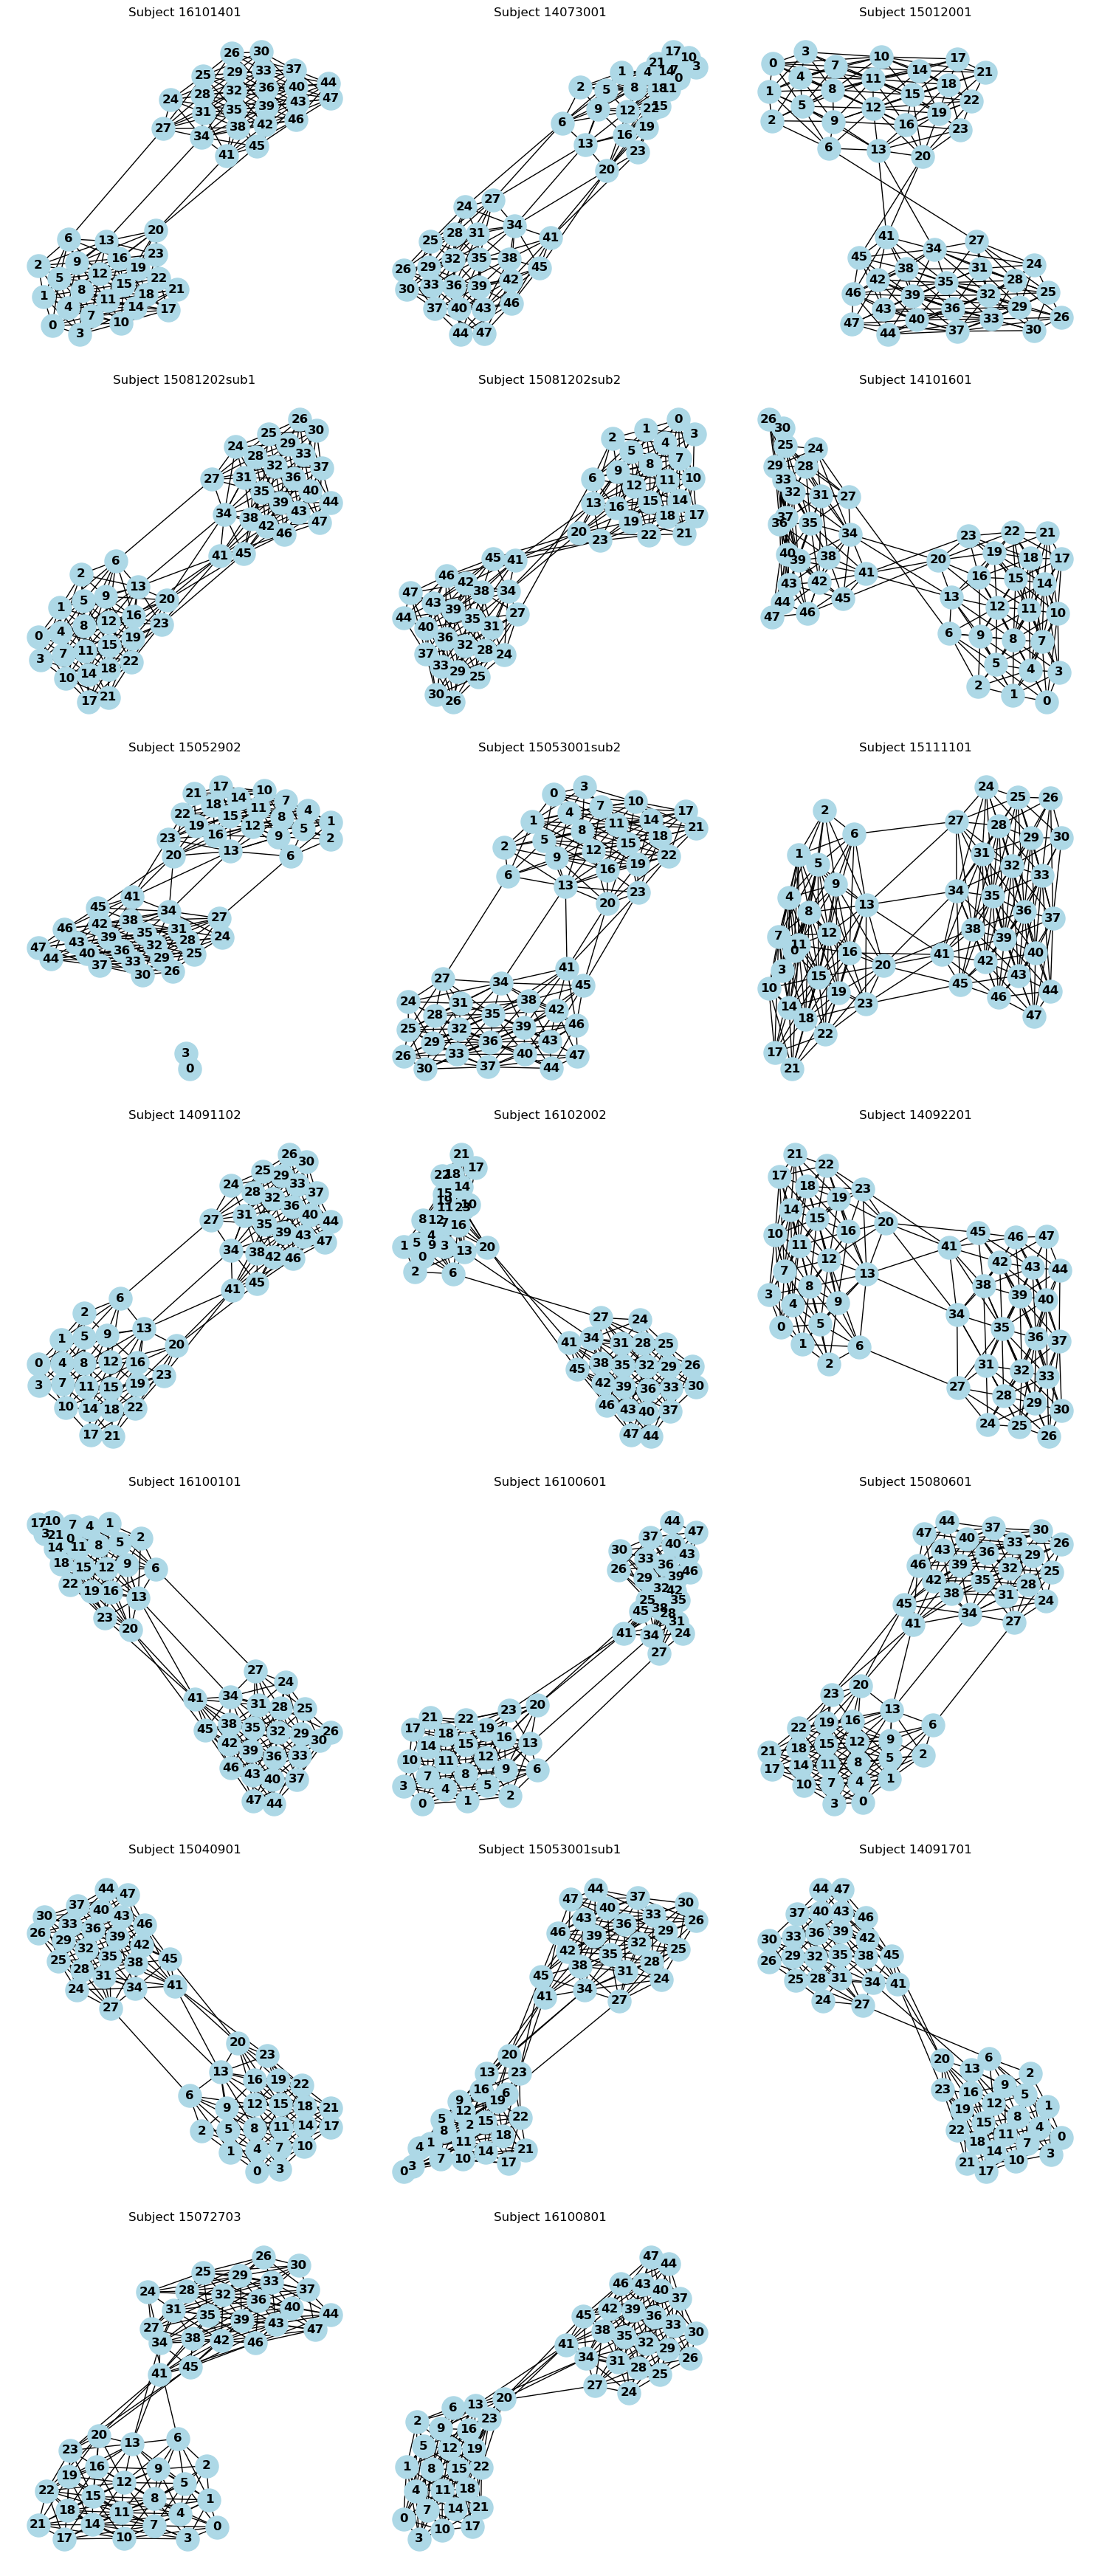

In [52]:
#################################
## GENERATE ADJACENCY MATRICES ##
#################################

THRESHOLD = 0.06
GRAPHS_PER_ROW = 3

def gaussian_kernel(x, y, sigma=20):
    return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * sigma ** 2))

def construct_adjacency_matrix(channel_coordinates, threshold):
    n_points = len(channel_coordinates)
    adj_matrix = np.zeros((n_points, n_points))
    
    for i in range(n_points):
        for j in range(i + 1, n_points):
            weight = gaussian_kernel(channel_coordinates[i], channel_coordinates[j])
            if weight > threshold:
                adj_matrix[i, j] = weight
                adj_matrix[j, i] = weight
                
    return adj_matrix

# Visualization
n_subjects = len(subject_channel_coords)
n_rows = (n_subjects + GRAPHS_PER_ROW - 1) // GRAPHS_PER_ROW

fig, axes = plt.subplots(n_rows, GRAPHS_PER_ROW, 
                        figsize=(5 * GRAPHS_PER_ROW, 5 * n_rows))
axes = axes.flatten()

for idx, (subject, coords) in enumerate(subject_channel_coords):
    ax = axes[idx]
    
    adj_matrix = construct_adjacency_matrix(coords, THRESHOLD)
    G = nx.from_numpy_array(adj_matrix)
    
    ax.set_title(f"Subject {subject}")
    nx.draw(G, ax=ax, with_labels=True, font_weight='bold', 
            node_size=500, node_color='lightblue')
    ax.axis('off')

for ax in axes[n_subjects:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [53]:
######################
## PREP FNIRS DATA ##
#####################

DATA_DIR = "/Users/judesack/THESIS_CODE/CLEANED_DATA/COMBINED PROBES"
file_pattern = os.path.join(DATA_DIR, "*_Combined_Probe_Difference.csv")
expected_shape = (7850, 48)
subject_data_matrices = []

def clean_data(df):
    df = df.apply(pd.to_numeric, errors='coerce')
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(df.mean(), inplace=True)
    return df

for file_path in glob.glob(file_pattern):
    subject_id = os.path.basename(file_path).split("_")[0]
    df = pd.read_csv(file_path)
    
    # Skip files with wrong shapes
    if df.shape != expected_shape:
        print(f"Excluding Subject {subject_id}: shape {df.shape} ≠ {expected_shape}")
        continue
    
    cleaned_df = clean_data(df)
    subject_data_matrices.append((subject_id, cleaned_df.values))

# Verify processing
print(f"\nProcessed {len(subject_data_matrices)} subjects")
if len(subject_data_matrices) == 20:
    print("All subjects successfully processed")
else:
    print(f"Warning: Only {len(subject_data_matrices)}/20 subjects processed")

# Ensure XYZ and fNIRS matchup
xyz_subject_ids = [subj_id for subj_id, _ in subject_channel_coords]
fNIRS_subject_ids = [subject_id for subject_id, _ in subject_data_matrices]
xyz_subject_ids_sorted = sorted(xyz_subject_ids)
fNIRS_subject_ids_sorted = sorted(fNIRS_subject_ids)

if xyz_subject_ids_sorted == fNIRS_subject_ids_sorted:
    print("Subject IDs match between datasets")
else:
    print("Warning: Subject ID mismatch between datasets")

    missing_in_fNIRS = set(xyz_subject_ids) - set(fNIRS_subject_ids)
    missing_in_XYZ = set(fNIRS_subject_ids) - set(xyz_subject_ids)
    
    if missing_in_fNIRS:
        print(f"Missing in fNIRS data: {missing_in_fNIRS}")
    if missing_in_XYZ:
        print(f"Missing in XYZ data: {missing_in_XYZ}")


Excluding Subject 15081202sub1: shape (750, 48) ≠ (7850, 48)
Excluding Subject 15072703: shape (750, 48) ≠ (7850, 48)

Processed 17 subjects
Missing in fNIRS data: {'15072703', '15081202sub1', '14073001'}


In [54]:
#####################
## GSTH SCATTERING ##
#####################

THRESHOLD = 0.06
OUTPUT_DIR = "/Users/judesack/THESIS_CODE/GSTH/notebooks/scattering_coefficients/MLP_data_new"
os.makedirs(OUTPUT_DIR, exist_ok=True)

fnirs_dict = {subj_id: data for subj_id, data in subject_data_matrices}
xyz_dict = {subj_id: coords for subj_id, coords in subject_channel_coords}
common_subjects = set(fnirs_dict) & set(xyz_dict)

for subject_id in sorted(common_subjects):
    print(f"Processing subject {subject_id}")
    fnirs_data = fnirs_dict[subject_id]
    coords = xyz_dict[subject_id]
    
    adj_matrix = construct_adjacency_matrix(coords, THRESHOLD)
    ro = fnirs_data.T
    normalized_features = np.zeros_like(ro)
    
    for i in range(ro.shape[0]):
       
        channel_min = np.min(ro[i])
        channel_range = np.max(ro[i]) - channel_min
        if channel_range > 0:  
            normalized_features[i] = (ro[i] - channel_min) / channel_range
        else:
            normalized_features[i] = ro[i] 
    
    # Generate and save features
    features = generate_timepoint_feature(adj_matrix, normalized_features)
    features = features.T
    output_file = os.path.join(OUTPUT_DIR, f"subject_{subject_id}_scattering_coeffs.csv")
    np.savetxt(output_file, features, delimiter=',')

print(f"Generated features for {len(common_subjects)} subjects")

Processing subject 14091102
Processing subject 14091701
Processing subject 14092201
Processing subject 14101601
Processing subject 15012001
Processing subject 15040901
Processing subject 15052902
Processing subject 15053001sub1
Processing subject 15053001sub2
Processing subject 15080601
Processing subject 15081202sub2
Processing subject 15111101
Processing subject 16100101
Processing subject 16100601
Processing subject 16100801
Processing subject 16101401
Processing subject 16102002
Generated features for 17 subjects


In [55]:
##################################
## CREATE UNIVERSAL TASK LABELS ##
##################################


# Set experimental paradigm defintions 
TASK_SEGMENTS = [
    (0, 250, 'Pre'),
    (250, 650, 'Rest 1'),
    (650, 1050, 'Sham'),
    (1050, 1450, 'Rest 2'),
    (1450, 1850, 'Improv 1'),
    (1850, 2250, 'Rest 3'),
    (2250, 2650, 'Scale 1'),
    (2650, 3050, 'Rest 4'),
    (3050, 3450, 'Improv 2'),
    (3450, 3850, 'Rest 5'),
    (3850, 4250, 'Scale 2'),
    (4250, 4650, 'Rest 6'),
    (4650, 5050, 'Improv 3'),
    (5050, 5450, 'Rest 7'),
    (5450, 5850, 'Scale 3'),
    (5850, 6250, 'Rest 8'),
    (6250, 6650, 'Improv 4'),
    (6650, 7050, 'Rest 9'),
    (7050, 7450, 'Scale 4'),
    (7450, 7850, 'Rest 10')
]

def create_task_labels():
    n_timepoints = 7850
    detailed_labels = np.empty(n_timepoints, dtype='object')
    general_labels = np.empty(n_timepoints, dtype='object')
    timepoints = np.arange(n_timepoints)
    
    # Assign labels based on timepoint ranges
    for start, end, task_name in TASK_SEGMENTS:
        mask = (timepoints >= start) & (timepoints < end)
        detailed_labels[mask] = task_name
        
        if 'Rest' in task_name:
            general_labels[mask] = 'Rest'
        elif 'Improv' in task_name:
            general_labels[mask] = 'Improv'
        elif 'Scale' in task_name:
            general_labels[mask] = 'Scale'
        else:
            general_labels[mask] = 'Other'
    
    return detailed_labels, general_labels, timepoints

In [ ]:
##########################################
## COMBINED SCATTERING COEFFICIENT FILE ##
##########################################

#File locations
scattering_dir = "scattering_coefficients/MLP_data_new"
output_file = "scattering_coefficients/MLP_data_new/combined_data.csv"

def combine_scattering_data(scattering_dir, output_file):
    scattering_dir = Path(scattering_dir)
    scattering_files = list(scattering_dir.glob('subject_*_scattering_coeffs.csv'))
    if not scattering_files:
        raise ValueError(f"No scattering coefficient files found in {scattering_dir}")
    
    _, general_labels, timepoints = create_task_labels()
    all_data = []
    print(f"Processing {len(scattering_files)} subjects...")
    
    for file_path in scattering_files:
        subject_id = file_path.stem.split('_')[1]
        print(f"Processing subject {subject_id}...")
        
        subject_coeffs = np.loadtxt(file_path, delimiter=',')
        subject_df = pd.DataFrame(subject_coeffs)

        subject_df['subject_id'] = subject_id
        subject_df['time_index'] = timepoints
        subject_df['task'] = general_labels
        
        all_data.append(subject_df)
    
    # Combine all subjects
    combined_df = pd.concat(all_data, ignore_index=True)
    
    feature_cols = [f'feature_{i}' for i in range(768)]
    combined_df.columns = feature_cols + ['subject_id', 'time_index', 'task']
    
    # Print summary
    print(f"\nDataset: {len(combined_df)} samples, {len(feature_cols)} features")
    print(f"Task distribution:\n{combined_df['task'].value_counts()}")
    
    # Save combined dataset
    combined_df.to_csv(output_file, index=False)
    print(f"Data saved to {output_file}")
    
    return combined_df

combined_data = combine_scattering_data(scattering_dir, output_file)

Processing 17 subjects...
Processing subject 15080601...
Processing subject 15052902...
Processing subject 16102002...
Processing subject 14091102...
Processing subject 16100801...
Processing subject 16101401...
Processing subject 14101601...
Processing subject 14092201...
Processing subject 15053001sub1...
Processing subject 14091701...
Processing subject 15040901...
Processing subject 16100601...
Processing subject 15111101...
Processing subject 15081202sub2...
Processing subject 16100101...
Processing subject 15012001...
Processing subject 15053001sub2...

Dataset: 133450 samples, 768 features
Task distribution:
task
Rest      68000
Improv    27200
Scale     27200
Other     11050
Name: count, dtype: int64
Data saved to scattering_coefficients/MLP_data_new/combined_data.csv


In [ ]:
#################################
## MLP CLASSIFIER ARCHITECTURE ##
#################################

class BrainStateDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.features)
        
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class BrainStateClassifier(nn.Module):
    def __init__(self, input_dim=768):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        return self.model(x)

def prepare_data(data_path, test_size=0.2, random_state=42):
    df = pd.read_csv(data_path)
    df = df[df['task'].isin(['Rest', 'Improv', 'Scale'])]
    
    #Create labels
    task_to_label = {'Rest': 0, 'Improv': 1, 'Scale': 2}
    df['label'] = df['task'].map(task_to_label)
    
    #Extract features & labels
    feature_cols = [col for col in df.columns if col.startswith('feature_')]
    X = df[feature_cols].values
    y = df['label'].values
    
    # Print class distribution
    for task, label in task_to_label.items():
        count = np.sum(y == label)
        print(f"{task}: {count} ({count/len(y)*100:.1f}%)")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Create weighted sampler
    class_weights = 1.0 / np.bincount(y_train)
    sample_weights = class_weights[y_train]
    sampler = torch.utils.data.WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(y_train),
        replacement=True
    )
    
    train_dataset = BrainStateDataset(X_train, y_train)
    test_dataset = BrainStateDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, test_loader

In [ ]:
##################################
## MLP CLASSIFIER TRAINING LOOP ##
##################################

def train_and_evaluate(train_loader, test_loader, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using {device}")
    model = BrainStateClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    # Set training history
    train_losses = []
    train_accs = []
    
    print("Starting training...")
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
        
        # Log metrics
        avg_loss = epoch_loss / len(train_loader)
        accuracy = 100 * correct / total
        
        train_losses.append(avg_loss)
        train_accs.append(accuracy)
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}: Loss={avg_loss:.4f}, Acc={accuracy:.2f}%')
    
    # Evaluate on test data
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X.to(device))
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.numpy())
    
    # Print results
    print("\nTest Set Results:")
    print(classification_report(all_labels, all_preds, 
                              target_names=['Rest', 'Improv', 'Scale'],
                              digits=3))
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs)
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    
    plt.tight_layout()
    
    return model, all_preds, all_labels, {
        'losses': train_losses,
        'accuracies': train_accs
    }

/var/folders/wq/qc5c6y6n0y96dck20g1j0dnw0000gn/T/ipykernel_48707/1398365737.py:36: DtypeWarning: Columns (768) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


Rest: 68000 (55.6%)
Improv: 27200 (22.2%)
Scale: 27200 (22.2%)
Using cpu
Starting training...
Epoch 10/50: Loss=0.2487, Acc=90.62%
Epoch 20/50: Loss=0.2034, Acc=92.64%
Epoch 30/50: Loss=0.1801, Acc=93.63%
Epoch 40/50: Loss=0.1742, Acc=93.91%
Epoch 50/50: Loss=0.1654, Acc=94.28%

Test Set Results:
              precision    recall  f1-score   support

        Rest      0.986     0.952     0.969     13600
      Improv      0.948     0.986     0.967      5440
       Scale      0.935     0.979     0.956      5440

    accuracy                          0.965     24480
   macro avg      0.956     0.972     0.964     24480
weighted avg      0.966     0.965     0.965     24480


Accuracy: 0.965
Rest: P=0.986, R=0.952, F1=0.969, n=13600
Improv: P=0.948, R=0.986, F1=0.967, n=5440
Scale: P=0.935, R=0.979, F1=0.956, n=5440


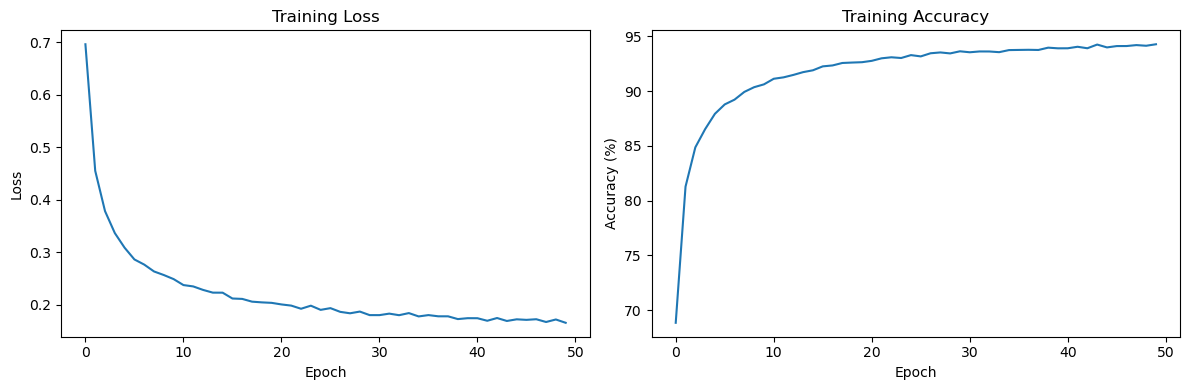

In [ ]:
###########################################
## MLP CLASSIFIER EXECUTION & EVALUATION ##
###########################################

#File locations
data_path = "scattering_coefficients/MLP_data_new/combined_data.csv"
results_dir = 'classification_results'

def generate_evaluation_report(test_preds, test_labels, train_losses, train_accs):
    results_dir = 'classification_results'
    os.makedirs(results_dir, exist_ok=True)
    
    # Calculate metrics
    accuracy = accuracy_score(test_labels, test_preds)
    precision, recall, f1, support = precision_recall_fscore_support(
        test_labels, test_preds, average=None
    )
    cm = confusion_matrix(test_labels, test_preds)
    print(f"\nAccuracy: {accuracy:.3f}")
    
    class_names = ['Rest', 'Improv', 'Scale']
    for i, name in enumerate(class_names):
        print(f"{name}: P={precision[i]:.3f}, R={recall[i]:.3f}, F1={f1[i]:.3f}, n={support[i]}")
    
    # Visualizations
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'{results_dir}/confusion_matrix.png')
    plt.close()
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Training curves
    axes[0,0].plot(train_losses)
    axes[0,0].set_title('Loss')
    axes[0,0].set_xlabel('Epoch')
    
    axes[0,1].plot(train_accs)
    axes[0,1].set_title('Accuracy')
    axes[0,1].set_xlabel('Epoch')
    
    # Performance metrics by class
    x = np.arange(3)
    width = 0.25
    
    axes[1,0].bar(x - width, precision, width, label='Precision')
    axes[1,0].bar(x, recall, width, label='Recall')
    axes[1,0].bar(x + width, f1, width, label='F1')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(class_names)
    axes[1,0].set_title('Metrics by Class')
    axes[1,0].legend()
    
    # Class distribution
    axes[1,1].bar(class_names, support)
    axes[1,1].set_title('Test Set Distribution')
    
    plt.tight_layout()
    plt.savefig(f'{results_dir}/performance_summary.png')
    plt.close()
    
    with open(f'{results_dir}/metrics.txt', 'w') as f:
        f.write(f"Accuracy: {accuracy:.3f}\n\n")
        for i, name in enumerate(class_names):
            f.write(f"{name}:\n")
            f.write(f"  Precision: {precision[i]:.3f}\n")
            f.write(f"  Recall: {recall[i]:.3f}\n")
            f.write(f"  F1: {f1[i]:.3f}\n")
            f.write(f"  Support: {support[i]}\n\n")


train_loader, test_loader = prepare_data(data_path)
model, preds, labels, metrics = train_and_evaluate(train_loader, test_loader)
generate_evaluation_report(preds, labels, metrics['losses'], metrics['accuracies'])
    
torch.save(model.state_dict(), f'{results_dir}/classifier.pth')
np.save(f'{results_dir}/predictions.npy', preds)
np.save(f'{results_dir}/labels.npy', labels)


In [60]:
##############################
## AUTOENCODER ARCHITECTURE ##
##############################

class BrainStateDataset(Dataset):
    def __init__(self, features, labels, subject_ids, time_indices):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
        self.subject_ids = subject_ids
        self.time_indices = torch.LongTensor(time_indices)
        
    def __len__(self):
        return len(self.features)
        
    def __getitem__(self, idx):
        return (self.features[idx], 
                self.labels[idx], 
                self.subject_ids[idx],
                self.time_indices[idx])

class BrainStateAutoencoder(nn.Module):
    def __init__(self, input_dim=768, latent_dim=5):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, input_dim)
        )
        
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z

class BrainStateFullModel(nn.Module):
    def __init__(self, input_dim=768, latent_dim=5, num_classes=3):
        super().__init__()
        self.autoencoder = BrainStateAutoencoder(input_dim, latent_dim)
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x):
        x_recon, z = self.autoencoder(x)
        logits = self.classifier(z)
        return x_recon, z, logits

def prepare_data(data_path, test_size=0.2, random_state=42):
    df = pd.read_csv(data_path)
    df = df[df['task'].isin(['Rest', 'Improv', 'Scale'])]
    
    task_to_label = {'Rest': 0, 'Improv': 1, 'Scale': 2}
    df['label'] = df['task'].map(task_to_label)
    df['subject_id'] = df['subject_id'].astype(str)
    df['time_index'] = df['time_index'].astype(int)
    
    # Extract features
    feature_cols = [col for col in df.columns if col.startswith('feature_')]
    X = df[feature_cols].values
    y = df['label'].values
    subject_ids = df['subject_id'].values
    time_indices = df['time_index'].values
    
    print(f"Data: {len(df)} samples, {len(feature_cols)} features")
    print(f"Subjects: {len(df['subject_id'].unique())}")
    print(f"Class distribution: {df['task'].value_counts().to_dict()}")
    
    # Split data into train & test sets
    X_train, X_test, y_train, y_test, subj_train, subj_test, time_train, time_test = train_test_split(
        X, y, subject_ids, time_indices,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    #Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    train_dataset = BrainStateDataset(X_train, y_train, subj_train, time_train)
    test_dataset = BrainStateDataset(X_test, y_test, subj_test, time_test)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    return train_loader, test_loader, (subj_train, subj_test)

In [ ]:
###############################
## AUTOENCODER TRAINING LOOP ##
###############################

#File locations
data_path = "scattering_coefficients/MLP_data_new/combined_data.csv"
results_dir = 'autoencoder_results'

def evaluate_model(model, train_loader, test_loader, device):
    model.eval()
    embeddings_dict = defaultdict(list)
    labels_dict = defaultdict(list)
    times_dict = defaultdict(list)
    
    with torch.no_grad():
        for loader in [train_loader, test_loader]:
            for batch_X, batch_y, batch_subjects, batch_times in loader:
                _, z, _ = model(batch_X.to(device))
                
                for i, subject in enumerate(batch_subjects):
                    embeddings_dict[subject].append(z[i].cpu().numpy())
                    labels_dict[subject].append(batch_y[i].item())
                    times_dict[subject].append(batch_times[i].item())
    
    return embeddings_dict, labels_dict, times_dict

def train_full_model(train_loader, test_loader, num_epochs=50, latent_dim=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using {device}")
    model = BrainStateFullModel(latent_dim=latent_dim).to(device)
    reconstruction_criterion = nn.MSELoss()
    classification_criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    history = {
        'train_total_loss': [],
        'train_recon_loss': [],
        'train_class_loss': [],
        'train_acc': [],
        'embeddings': defaultdict(list),
        'labels': defaultdict(list),
        'time_indices': defaultdict(list)
    }
    
    for epoch in range(num_epochs):
        model.train()
        epoch_total_loss = 0
        epoch_recon_loss = 0
        epoch_class_loss = 0
        correct = 0
        total = 0
        
        for batch_X, batch_y, _, _ in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            x_recon, z, logits = model(batch_X)
            
            recon_loss = reconstruction_criterion(x_recon, batch_X)
            class_loss = classification_criterion(logits, batch_y)
            total_loss = recon_loss + class_loss
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            epoch_total_loss += total_loss.item()
            epoch_recon_loss += recon_loss.item()
            epoch_class_loss += class_loss.item()
            
            _, predicted = torch.max(logits.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
        
        train_acc = 100 * correct / total
        avg_total = epoch_total_loss / len(train_loader)
        avg_recon = epoch_recon_loss / len(train_loader)
        avg_class = epoch_class_loss / len(train_loader)
        
        history['train_total_loss'].append(avg_total)
        history['train_recon_loss'].append(avg_recon)
        history['train_class_loss'].append(avg_class)
        history['train_acc'].append(train_acc)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_total:.4f} (R: {avg_recon:.4f}, C: {avg_class:.4f}), Acc: {train_acc:.2f}%")
    
    print("Collecting embeddings...")
    embeddings_dict, labels_dict, times_dict = evaluate_model(model, train_loader, test_loader, device)
    
    for subject in embeddings_dict:
        times = np.array(times_dict[subject])
        sort_idx = np.argsort(times)
        
        history['embeddings'][subject] = np.array(embeddings_dict[subject])[sort_idx]
        history['labels'][subject] = np.array(labels_dict[subject])[sort_idx]
        history['time_indices'][subject] = times[sort_idx]
    
    return model, history

# Run autoencoder
train_loader, test_loader, (train_subjects, test_subjects) = prepare_data(data_path)
model, history = train_full_model(
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=50,
    latent_dim=5
)    

os.makedirs(results_dir, exist_ok=True)
torch.save({
    'model_state_dict': model.state_dict(),
    'history': history,
    'train_subjects': train_subjects,
    'test_subjects': test_subjects
}, f'{results_dir}/model_results.pth')
    
print(f"Training complete - results saved to {results_dir}")

/var/folders/wq/qc5c6y6n0y96dck20g1j0dnw0000gn/T/ipykernel_48707/4249173405.py:67: DtypeWarning: Columns (768) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


Data: 122400 samples, 768 features
Subjects: 17
Class distribution: {'Rest': 68000, 'Improv': 27200, 'Scale': 27200}
Using cpu
Epoch 10/50 - Loss: 0.5547 (R: 0.2975, C: 0.2573), Acc: 90.44%
Epoch 20/50 - Loss: 0.4876 (R: 0.2989, C: 0.1887), Acc: 93.20%
Epoch 30/50 - Loss: 0.4586 (R: 0.2984, C: 0.1602), Acc: 94.37%
Epoch 40/50 - Loss: 0.4439 (R: 0.3011, C: 0.1427), Acc: 95.01%
Epoch 50/50 - Loss: 0.4297 (R: 0.2989, C: 0.1307), Acc: 95.47%
Training complete - results saved to autoencoder_results


/var/folders/wq/qc5c6y6n0y96dck20g1j0dnw0000gn/T/ipykernel_48707/1438210137.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(results_path)
/var/folders/

Data: 122400 samples, 768 features
Subjects: 17
Class distribution: {'Rest': 68000, 'Improv': 27200, 'Scale': 27200}

Autoencoder Test Set Classification Report:
              precision    recall  f1-score   support

        Rest      0.989     0.978     0.984     13600
      Improv      0.984     0.981     0.982      5440
       Scale      0.958     0.988     0.973      5440

    accuracy                          0.981     24480
   macro avg      0.977     0.982     0.980     24480
weighted avg      0.981     0.981     0.981     24480


Confusion Matrix:
[[13302    77   221]
 [   91  5334    15]
 [   52    11  5377]]


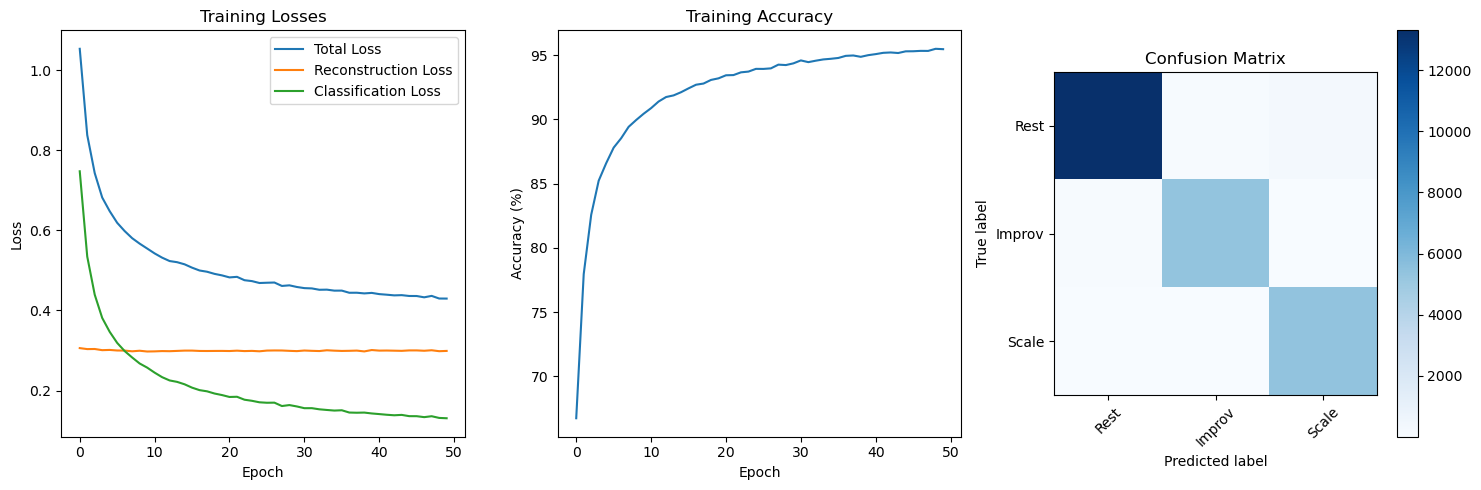


Final Training Performance:
Training Accuracy: 95.47%
Total Loss: 0.4297
Reconstruction Loss: 0.2989


In [62]:
###################################
## EXTRA RESULTS FOR AUTOENCODER ##
###################################

def evaluate_autoencoder_performance():
    results_path = f'{results_dir}/model_results.pth'
    data = torch.load(results_path)
    model_state = data['model_state_dict']
    history = data['history']
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = BrainStateFullModel(latent_dim=5).to(device)
    model.load_state_dict(model_state)
    model.eval()
    
    train_loader, test_loader, _ = prepare_data(data_path)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y, _, _ in test_loader:
            batch_X = batch_X.to(device)
            _, _, logits = model(batch_X)
            _, predicted = torch.max(logits.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.numpy())
    
    print("\nAutoencoder Test Set Classification Report:")
    print(classification_report(all_labels, all_preds, 
                              target_names=['Rest', 'Improv', 'Scale'],
                              digits=3))
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Training losses
    axes[0].plot(history['train_total_loss'], label='Total Loss')
    axes[0].plot(history['train_recon_loss'], label='Reconstruction Loss')
    axes[0].plot(history['train_class_loss'], label='Classification Loss')
    axes[0].set_title('Training Losses')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    # Training accuracy
    axes[1].plot(history['train_acc'])
    axes[1].set_title('Training Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy (%)')
    
    # Confusion matrix 
    cm = confusion_matrix(all_labels, all_preds)
    print("\nConfusion Matrix:")
    print(cm)
    im = axes[2].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[2].set_title('Confusion Matrix')
    plt.colorbar(im, ax=axes[2])
    tick_marks = np.arange(3)
    axes[2].set_xticks(tick_marks)
    axes[2].set_xticklabels(['Rest', 'Improv', 'Scale'], rotation=45)
    axes[2].set_yticks(tick_marks)
    axes[2].set_yticklabels(['Rest', 'Improv', 'Scale'])
    axes[2].set_ylabel('True label')
    axes[2].set_xlabel('Predicted label')
    
    plt.tight_layout()
    plt.show()
    
    print("\nFinal Training Performance:")
    print(f"Training Accuracy: {history['train_acc'][-1]:.2f}%")
    print(f"Total Loss: {history['train_total_loss'][-1]:.4f}")
    print(f"Reconstruction Loss: {history['train_recon_loss'][-1]:.4f}")

evaluate_autoencoder_performance()

Computing PHATE embedding...


/var/folders/wq/qc5c6y6n0y96dck20g1j0dnw0000gn/T/ipykernel_48707/1835653292.py:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load(results_path)
/Users/j

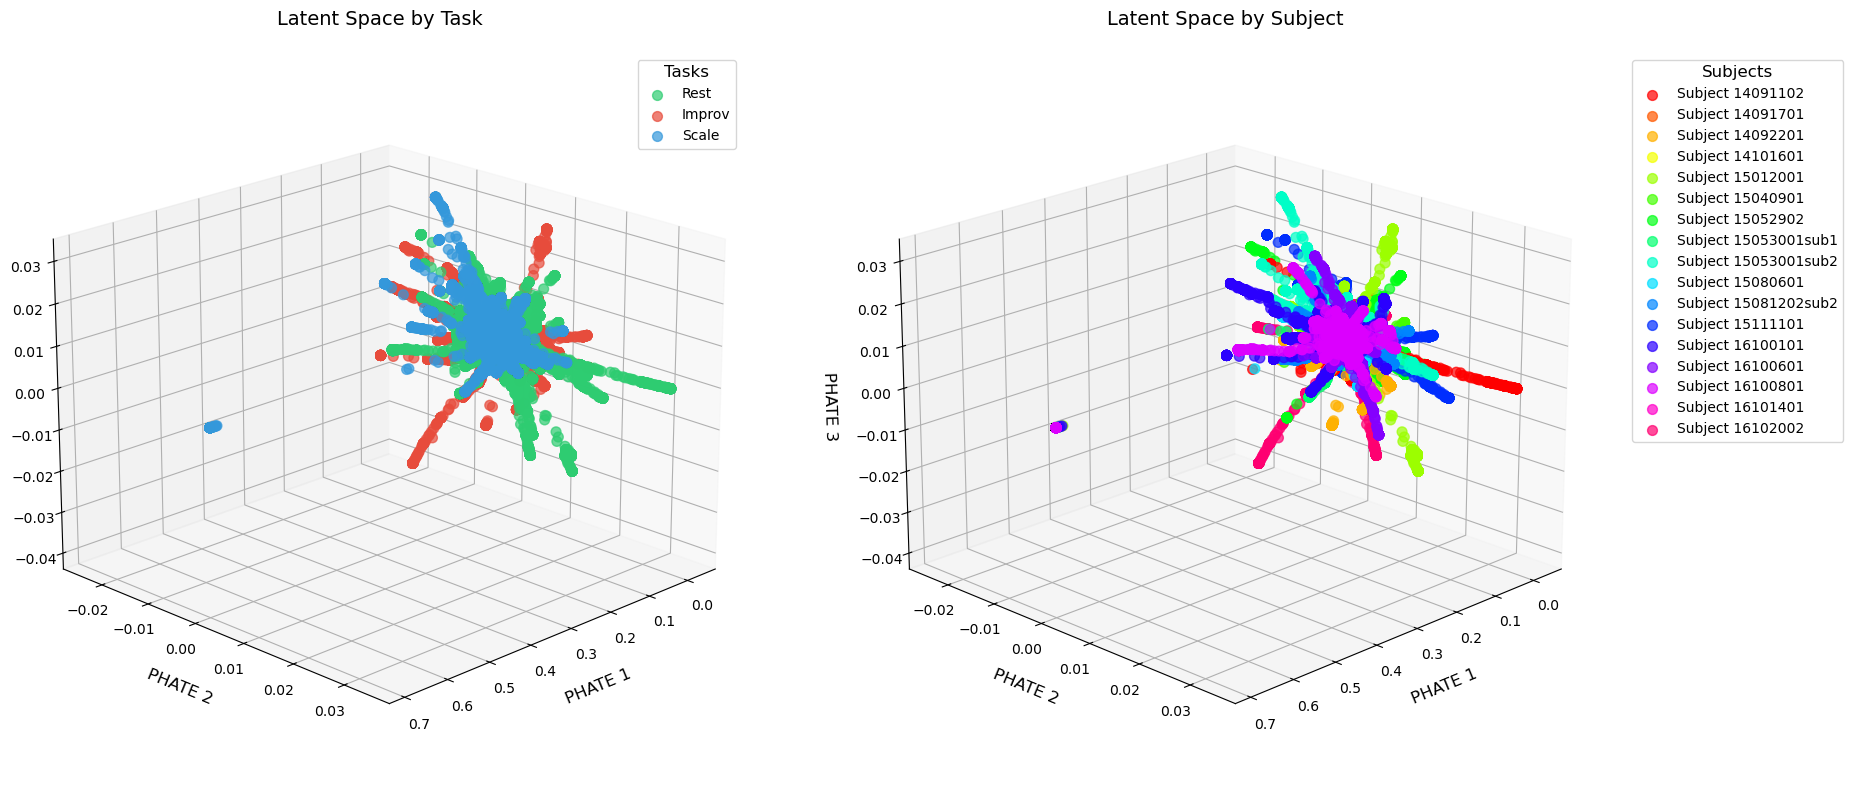

Filtered shape (rest excluded): (54400, 5)
Computing PHATE embedding (rest excluded)...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 16415 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))
/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


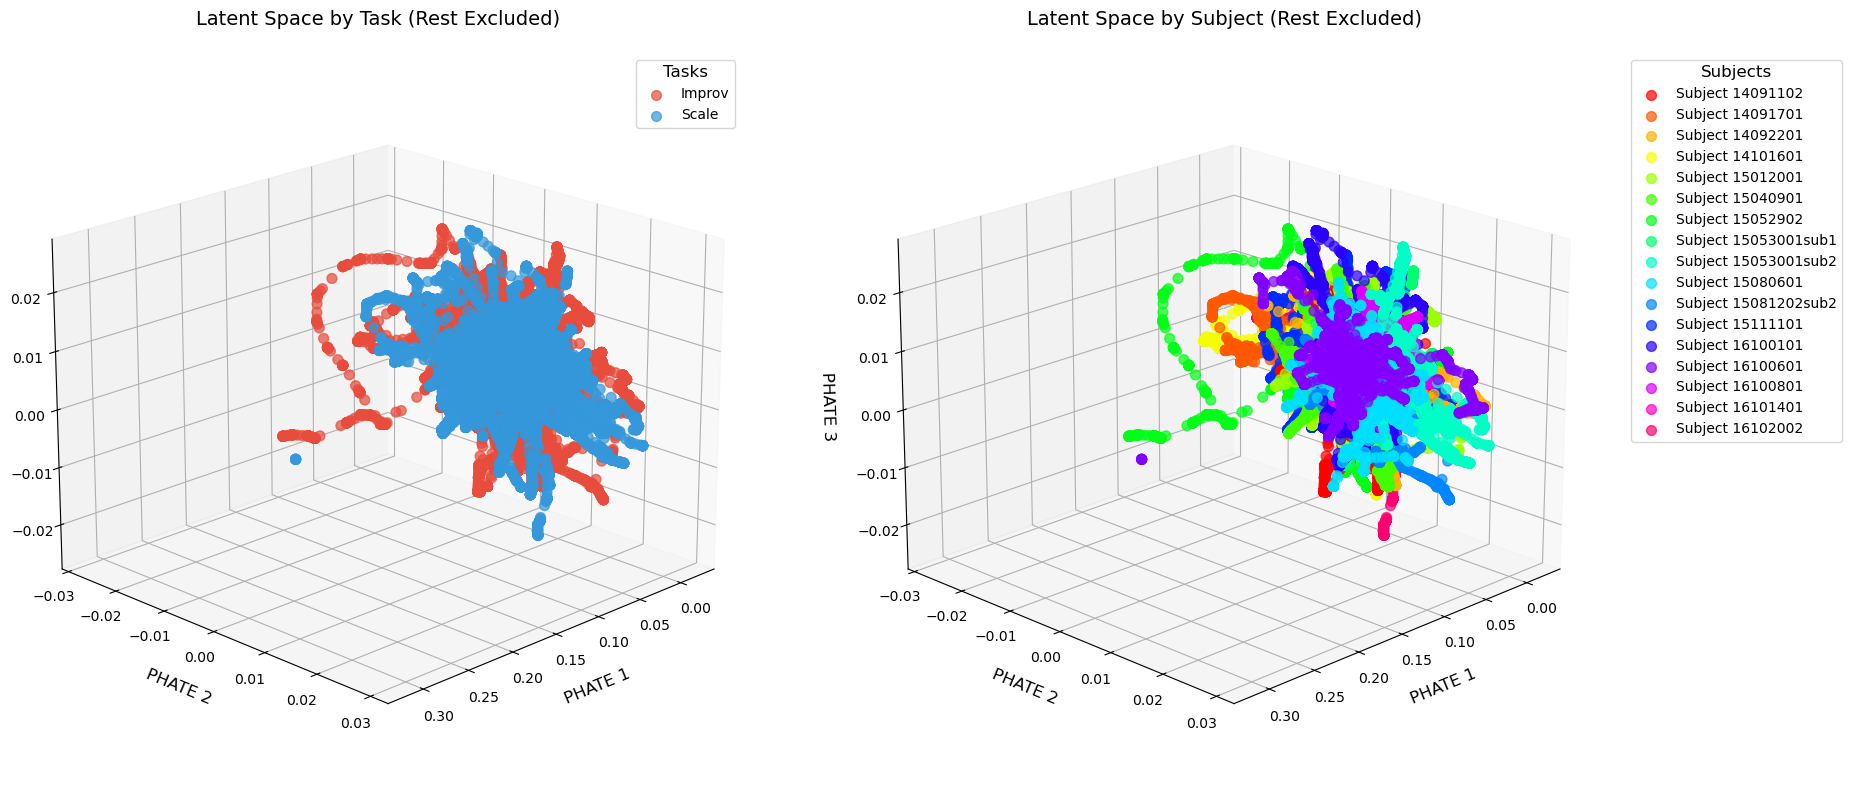

In [ ]:
#################################
## EMBED LATENT SPACE IN PHATE ##
#################################

MARKER_SIZE = 50
ALPHA = 0.7
DIFFUSION_TIME = 200

#Embed latent spaces with PHATE
def visualize_latent_space(latent_space, labels, subjects, include_rest=True):
    latent_space = np.array(latent_space)
    labels = np.array(labels)
    subjects = np.array(subjects)
    
    # Filter data
    if not include_rest:
        rest_mask = labels != 0
        latent_space = latent_space[rest_mask]
        labels = labels[rest_mask]
        subjects = subjects[rest_mask]
        print(f"Filtered shape (rest excluded): {latent_space.shape}")
    
    print(f"Computing PHATE embedding{' (rest excluded)' if not include_rest else ''}...")
    
    phate_op = phate.PHATE(
        n_components=3,
        t=DIFFUSION_TIME,
        random_state=42,
        n_jobs=-1,
        verbose=False
    )
    embedding = phate_op.fit_transform(latent_space)
    
    # Create visualization
    fig = plt.figure(figsize=(20, 8))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    if include_rest:
        task_colors = ['#2ecc71', '#e74c3c', '#3498db']
        task_names = ['Rest', 'Improv', 'Scale']
    else:
        task_colors = ['#e74c3c', '#3498db']
        task_names = ['Improv', 'Scale']
    
    # Plot by task
    for i, (task, color) in enumerate(zip(task_names, task_colors)):
        label_idx = i if include_rest else i+1
        mask = labels == label_idx
        ax1.scatter(
            embedding[mask, 0],
            embedding[mask, 1],
            embedding[mask, 2],
            c=color,
            label=task,
            alpha=ALPHA,
            s=MARKER_SIZE
        )
    
    title_suffix = " (Rest Excluded)" if not include_rest else ""
    ax1.set_title(f'Latent Space by Task{title_suffix}', fontsize=14, pad=20)
    ax1.set_xlabel('PHATE 1', fontsize=12, labelpad=10)
    ax1.set_ylabel('PHATE 2', fontsize=12, labelpad=10)
    ax1.set_zlabel('PHATE 3', fontsize=12, labelpad=10)
    ax1.legend(fontsize=10, title='Tasks', title_fontsize=12)
    
    # Plot by subject
    unique_subjects = sorted(np.unique(subjects))
    n_subjects = len(unique_subjects)
    subject_colors = [plt.cm.hsv(i/n_subjects) for i in range(n_subjects)]
    
    for i, subject in enumerate(unique_subjects):
        mask = subjects == subject
        ax2.scatter(
            embedding[mask, 0],
            embedding[mask, 1],
            embedding[mask, 2],
            c=[subject_colors[i]],
            label=f'Subject {subject}',
            alpha=ALPHA,
            s=MARKER_SIZE
        )
    
    ax2.set_title(f'Latent Space by Subject{title_suffix}', fontsize=14, pad=20)
    ax2.set_xlabel('PHATE 1', fontsize=12, labelpad=10)
    ax2.set_ylabel('PHATE 2', fontsize=12, labelpad=10)
    ax2.set_zlabel('PHATE 3', fontsize=12, labelpad=10)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10,
              title='Subjects', title_fontsize=12)
    
    for ax in [ax1, ax2]:
        ax.view_init(elev=20, azim=45)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

#Load data & make visualizations
def run_visualization():
    results_path = 'autoencoder_results/model_results.pth'
    results = torch.load(results_path)
    
    # Combine subject data
    all_spaces = []
    all_labels = []
    all_subjects = []
    for subject, embeddings in results['history']['embeddings'].items():
        all_spaces.append(embeddings)
        all_labels.extend(results['history']['labels'][subject])
        all_subjects.extend([subject] * len(results['history']['labels'][subject]))
    latent_space = np.vstack(all_spaces)
    
    visualize_latent_space(latent_space, all_labels, all_subjects, include_rest=True)
    visualize_latent_space(latent_space, all_labels, all_subjects, include_rest=False)

run_visualization()

In [ ]:
#####################################
## RESHAPE SCATTERING COEFFICIENTS ##
#####################################

scattering_dir = "scattering_coefficients/MLP_data_new"

def load_and_reshape_scattering_coeffs(scattering_dir):
    scattering_dir = Path(scattering_dir)
    scattering_files = list(scattering_dir.glob('subject_*_scattering_coeffs.csv'))
    first_file = np.loadtxt(scattering_files[0], delimiter=',')
    num_timepoints, num_features = first_file.shape
    sample_data = first_file.T  # features x timepoints

    F0 = sample_data[:48]  
    F1 = sample_data[48:48+48*5]  
    F2 = sample_data[48+48*5:] 
    print(f"F0: {F0.shape}, F1: {F1.shape}, F2: {F2.shape}")
    
    reshaped = reshape_features(F0, F1, F2, sample_data)
    return {
        'F0': F0,
        'F1': F1,
        'F2': F2,
        'F': sample_data,
        'reshaped': reshaped
    }

def reshape_features(F0, F1, F2, F):
    num_nodes = 48
    num_timepoints = F.shape[1]
    features_per_node = 16
    
    reshaped = np.zeros((num_nodes, features_per_node, num_timepoints))
    reshaped[:, 0, :] = F0
    for i in range(num_nodes):
        reshaped[i, 1:6, :] = F1[i*5:(i+1)*5, :]  
        reshaped[i, 6:16, :] = F2[i*10:(i+1)*10, :]
    
    #Validate
    flattened = reshaped.reshape(-1, num_timepoints)
    error = np.mean(np.abs(flattened - F))
    print(f"Reshaped to {reshaped.shape}, error: {error:.6f}")
    
    return reshaped

features = load_and_reshape_scattering_coeffs(scattering_dir)

F0: (48, 7850), F1: (240, 7850), F2: (480, 7850)
Reshaped to (48, 16, 7850), error: 0.062774


In [67]:
######################################################
## DEFINING AUTOENCODER ARCHITECTURE WITH ATTENTION ##
######################################################

#Should I just be reusing the autoencoder or creating a new one? Ask Dhanajay about this.

class NodeAttention(nn.Module):
    def __init__(self, num_nodes=48):
        super().__init__()
        self.alphas = nn.Parameter(torch.ones(num_nodes))
        
    def forward(self, x):
        if len(x.shape) == 2:
            batch_size = x.size(0)
            x = x.view(batch_size, 48, 16)
            
        alphas_expanded = self.alphas.view(1, -1, 1)
        weighted_features = x * alphas_expanded
        
        if len(x.shape) == 2:
            return weighted_features.reshape(batch_size, -1)
        return weighted_features


class AttentionAutoencoder(nn.Module):
    def __init__(self, input_dim=768, latent_dim=5):
        super().__init__()
        
        self.node_attention = NodeAttention()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, latent_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, input_dim)
        )
        
    def forward(self, x):
        x = self.node_attention(x)
        
        if len(x.shape) > 2:
            x = x.reshape(x.size(0), -1)
            
        z = self.encoder(x)
        x_recon = self.decoder(z)
        
        return x_recon, z


class AttentionFullModel(nn.Module):
    def __init__(self, input_dim=768, latent_dim=5, num_classes=3):
        super().__init__()
        self.autoencoder = AttentionAutoencoder(input_dim, latent_dim)
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x_recon, z = self.autoencoder(x)
        logits = self.classifier(z)
        return x_recon, z, logits


/var/folders/wq/qc5c6y6n0y96dck20g1j0dnw0000gn/T/ipykernel_48707/4249173405.py:67: DtypeWarning: Columns (768) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path)


Data: 122400 samples, 768 features
Subjects: 17
Class distribution: {'Rest': 68000, 'Improv': 27200, 'Scale': 27200}
Epoch 10/50 - Loss: 0.5218 (R: 0.2823, C: 0.2395), Acc: 91.05%
Epoch 20/50 - Loss: 0.4260 (R: 0.2617, C: 0.1643), Acc: 94.07%
Epoch 30/50 - Loss: 0.3858 (R: 0.2530, C: 0.1328), Acc: 95.29%
Epoch 40/50 - Loss: 0.3624 (R: 0.2472, C: 0.1152), Acc: 96.02%
Epoch 50/50 - Loss: 0.3500 (R: 0.2444, C: 0.1056), Acc: 96.38%
Results saved to attention_results


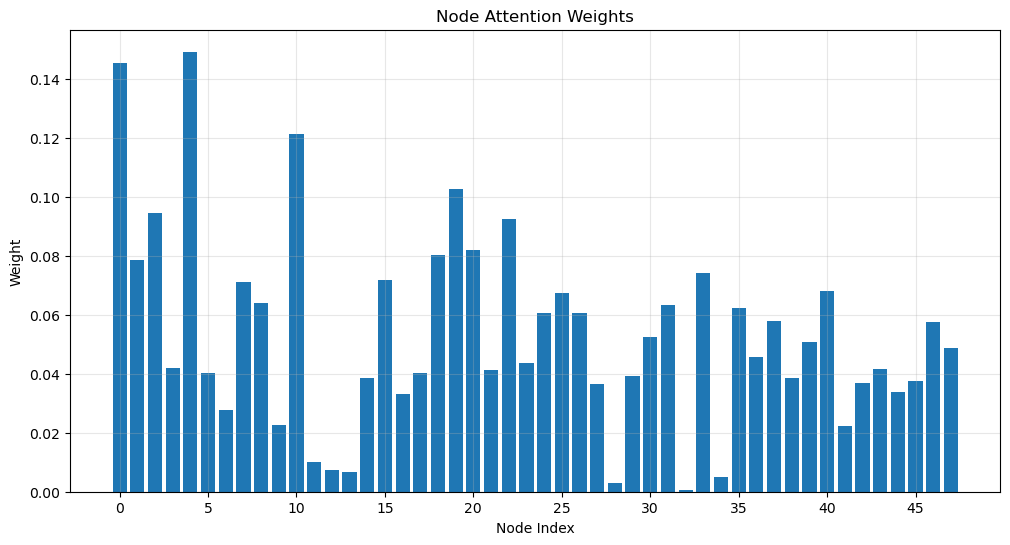

In [68]:
########################################
## RUNNING AUTOENCODER WITH ATTENTION ##
########################################

data_path = "scattering_coefficients/MLP_data_new/combined_data.csv"
results_dir = 'attention_results'
os.makedirs(results_dir, exist_ok=True)

def train_attention_model(train_loader, test_loader, num_epochs=50, latent_dim=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = AttentionFullModel(latent_dim=latent_dim).to(device)
    recon_loss_fn = nn.MSELoss()
    class_loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    history = {
        'total_loss': [],
        'recon_loss': [],
        'class_loss': [],
        'accuracy': [],
        'attention_weights': [],
        'embeddings': defaultdict(list),
        'labels': defaultdict(list),
        'times': defaultdict(list)
    }
    
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = {'total': 0, 'recon': 0, 'class': 0}
        correct, total = 0, 0
        
        for batch_X, batch_y, _, _ in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            x_recon, z, logits = model(batch_X)
            
            recon_loss = recon_loss_fn(x_recon, batch_X)
            class_loss = class_loss_fn(logits, batch_y)
            total_loss = recon_loss + class_loss
            
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
            
            epoch_losses['total'] += total_loss.item()
            epoch_losses['recon'] += recon_loss.item()
            epoch_losses['class'] += class_loss.item()
            
            _, predicted = torch.max(logits, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
        
        n_batches = len(train_loader)
        epoch_avg = {k: v/n_batches for k, v in epoch_losses.items()}
        accuracy = 100 * correct / total
        
        history['total_loss'].append(epoch_avg['total'])
        history['recon_loss'].append(epoch_avg['recon'])
        history['class_loss'].append(epoch_avg['class'])
        history['accuracy'].append(accuracy)
        history['attention_weights'].append(
            model.autoencoder.node_attention.alphas.detach().cpu().numpy()
        )
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_avg['total']:.4f} (R: {epoch_avg['recon']:.4f}, C: {epoch_avg['class']:.4f}), Acc: {accuracy:.2f}%")
    
    #Collect & sort embeddings
    model.eval()
    with torch.no_grad():
        for loader in [train_loader, test_loader]:
            for batch_X, batch_y, batch_subjects, batch_times in loader:
                _, z, _ = model(batch_X.to(device))
    
    
                for i, subject in enumerate(batch_subjects):
                    history['embeddings'][subject].append(z[i].cpu().numpy())
                    history['labels'][subject].append(batch_y[i].item())
                    history['times'][subject].append(batch_times[i].item())

    for subject in history['embeddings']:
        times = np.array(history['times'][subject])
        sort_idx = np.argsort(times)
        
        history['embeddings'][subject] = np.array(history['embeddings'][subject])[sort_idx]
        history['labels'][subject] = np.array(history['labels'][subject])[sort_idx]
        history['times'][subject] = times[sort_idx]
    
    return model, history

#Bar Graph Visualization
def plot_attention_weights(weights):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(weights)), weights)
    plt.title('Node Attention Weights')
    plt.xlabel('Node Index')
    plt.ylabel('Weight')
    plt.xticks(range(0, len(weights), 5))
    plt.grid(True, alpha=0.3)

#Run autoencoder
train_loader, test_loader, _ = prepare_data(data_path) 
model, history = train_attention_model(
    train_loader=train_loader,
    test_loader=test_loader,
    num_epochs=50,
    latent_dim=5
    )  

#Visualize weights
plot_attention_weights(history['attention_weights'][-1])
    
# Save results
torch.save({
    'model_state_dict': model.state_dict(),
    'history': history,
}, os.path.join(results_dir, 'attention_model_results.pth'))   
print(f"Results saved to {results_dir}")

/var/folders/wq/qc5c6y6n0y96dck20g1j0dnw0000gn/T/ipykernel_48707/729103673.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  results = torch.load(results_path)
/var/fold

Data: 122400 samples, 768 features
Subjects: 17
Class distribution: {'Rest': 68000, 'Improv': 27200, 'Scale': 27200}
Computing PHATE embedding...
Calculating PHATE...
  Running PHATE on 122400 observations and 5 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 10.86 seconds.
    Calculating affinities...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 2572 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated affinities in 0.27 seconds.
  Calculated graph and diffusion operator in 11.17 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 3.18 seconds.
    Calculating KMeans...
    Calculated KMeans in 74.44 seconds.
  Calculated landmark operator in 79.11 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.36 seconds.
  Calculating metric MDS...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 72.86 seconds.
Calculated PHATE in 163.51 seconds.


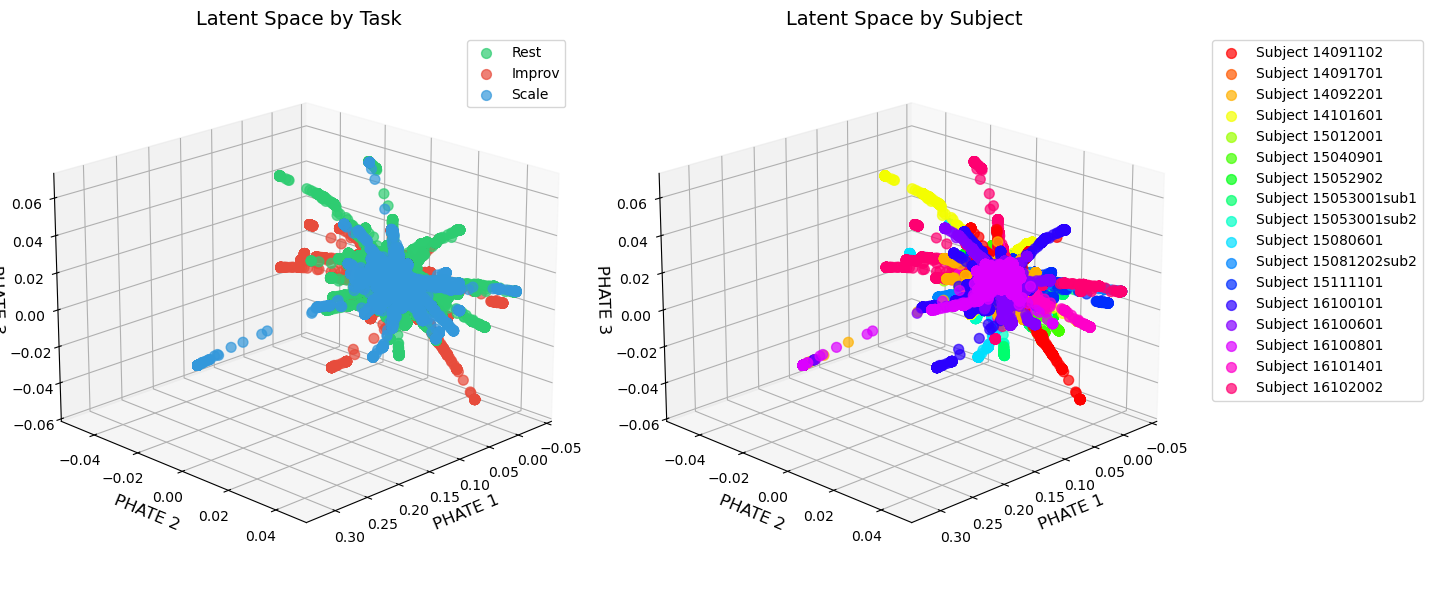

Filtered shape (rest excluded): (54400, 5)
Computing PHATE embedding (rest excluded)...
Calculating PHATE...
  Running PHATE on 54400 observations and 5 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 3.03 seconds.
    Calculating affinities...
    Calculated affinities in 0.16 seconds.
  Calculated graph and diffusion operator in 3.21 seconds.
  Calculating landmark operator...
    Calculating SVD...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:290: RuntimeWarning: Detected zero distance between 2572 pairs of samples. Consider removing duplicates to avoid errors in downstream processing.
  warnings.warn(
/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/graphtools/graphs.py:454: RuntimeWarning: overflow encountered in power
  K.data = np.exp(-1 * np.power(K.data, self.decay))


    Calculated SVD in 1.42 seconds.
    Calculating KMeans...
    Calculated KMeans in 83.55 seconds.
  Calculated landmark operator in 85.70 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.36 seconds.
  Calculating metric MDS...


/Users/judesack/miniforge3/envs/gsth_env/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


  Calculated metric MDS in 62.61 seconds.
Calculated PHATE in 151.88 seconds.


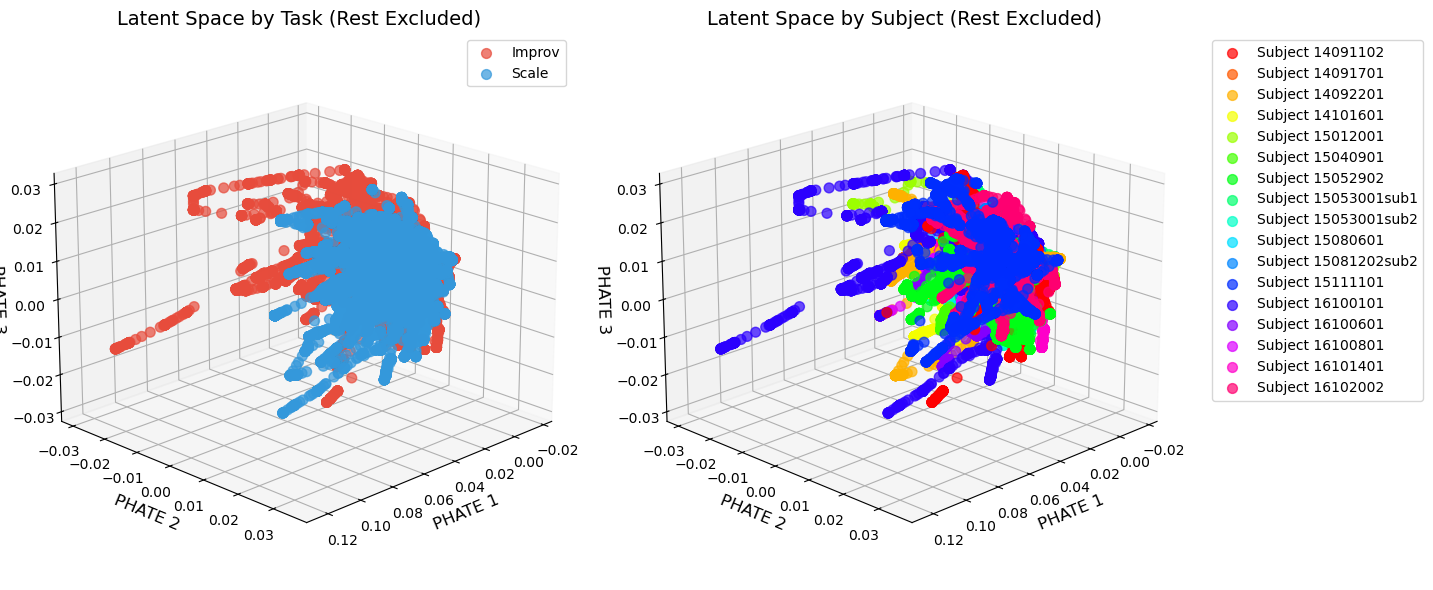

In [ ]:
###############################################
## VISUALIZE NEW LATENT SPACE WITH ATTENTION ##
###############################################

T_VALUE = 200
MARKER_SIZE = 50
ALPHA = 0.7

#Embed latent space in PHATE (w/ attention)
def visualize_attention_latent_space(latent_space, labels, subjects, attention_weights, include_rest=True):
    latent_space = np.array(latent_space)
    labels = np.array(labels)
    subjects = np.array(subjects)
    
    if not include_rest:
        non_rest_mask = labels != 0
        latent_space = latent_space[non_rest_mask]
        labels = labels[non_rest_mask]
        subjects = subjects[non_rest_mask]
        print(f"Filtered shape (rest excluded): {latent_space.shape}")
    
    print(f"Computing PHATE embedding{' (rest excluded)' if not include_rest else ''}...")
    
    phate_op = phate.PHATE(
        n_components=3,
        t=T_VALUE,
        random_state=42,
        n_jobs=-1,
        verbose=True
    )
    embedding = phate_op.fit_transform(latent_space)
    
    #Setup visualization
    fig = plt.figure(figsize=(15, 6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    if include_rest:
        task_colors = ['#2ecc71', '#e74c3c', '#3498db']  
        task_names = ['Rest', 'Improv', 'Scale']
    else:
        task_colors = ['#e74c3c', '#3498db'] 
        task_names = ['Improv', 'Scale']
    
    # Plot by task
    for i, (task, color) in enumerate(zip(task_names, task_colors)):
        label_idx = i if include_rest else i+1
        mask = labels == label_idx
        ax1.scatter(
            embedding[mask, 0],
            embedding[mask, 1],
            embedding[mask, 2],
            c=color,
            label=task,
            alpha=ALPHA,
            s=MARKER_SIZE
        )
    
    title_suffix = " (Rest Excluded)" if not include_rest else ""
    ax1.set_title(f'Latent Space by Task{title_suffix}', fontsize=14)
    ax1.set_xlabel('PHATE 1', fontsize=12)
    ax1.set_ylabel('PHATE 2', fontsize=12)
    ax1.set_zlabel('PHATE 3', fontsize=12)
    ax1.legend(fontsize=10)
    
    #Plot by subject
    unique_subjects = sorted(np.unique(subjects))
    n_subjects = len(unique_subjects)
    subject_colors = [plt.cm.hsv(i/n_subjects) for i in range(n_subjects)]
    
    for i, subject in enumerate(unique_subjects):
        mask = subjects == subject
        ax2.scatter(
            embedding[mask, 0],
            embedding[mask, 1],
            embedding[mask, 2],
            c=[subject_colors[i]],
            label=f'Subject {subject}',
            alpha=ALPHA,
            s=MARKER_SIZE
        )
    
    ax2.set_title(f'Latent Space by Subject{title_suffix}', fontsize=14)
    ax2.set_xlabel('PHATE 1', fontsize=12) 
    ax2.set_ylabel('PHATE 2', fontsize=12)
    ax2.set_zlabel('PHATE 3', fontsize=12)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    for ax in [ax1, ax2]:
        ax.view_init(elev=20, azim=45)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


#Extract embeddings & attention weights
def collect_attention_embeddings(model, train_loader, test_loader, device):
    model.eval()
    embeddings = defaultdict(list)
    labels = defaultdict(list)
    times = defaultdict(list)
    
    with torch.no_grad():
        for loader in [train_loader, test_loader]:
            for batch_X, batch_y, batch_subjects, batch_times in loader:
                _, z, _ = model(batch_X.to(device))
                
                for i, subject in enumerate(batch_subjects):
                    embeddings[subject].append(z[i].cpu().numpy())
                    labels[subject].append(batch_y[i].item())
                    times[subject].append(batch_times[i].item())
    
    return embeddings, labels, times

def run_attention_visualization():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    #Load model
    results_path = 'attention_results/attention_model_results.pth'
    results = torch.load(results_path)
    model = AttentionFullModel(latent_dim=5)
    model.load_state_dict(results['model_state_dict'])
    model = model.to(device)
    train_loader, test_loader, _ = prepare_data("scattering_coefficients/MLP_data_new/combined_data.csv")

    embeddings, labels, times = collect_attention_embeddings(model, train_loader, test_loader, device)
    
    # Combine data
    all_embeddings = []
    all_labels = []
    all_subjects = []
    
    for subject, subj_embeddings in embeddings.items():
        all_embeddings.append(np.array(subj_embeddings))
        all_labels.extend(labels[subject])
        all_subjects.extend([subject] * len(labels[subject]))
    
    latent_space = np.vstack(all_embeddings)
    
    visualize_attention_latent_space(latent_space, all_labels, all_subjects, None, include_rest=True)
    visualize_attention_latent_space(latent_space, all_labels, all_subjects, None, include_rest=False)

run_attention_visualization()